
The list of methods that can be applied to ratio metrics discussed during the lecture is not exhaustive. There are a huge number of useful materials on this topic. Let's start with the [materials](https://vkteam.medium.com/practitioners-guide-to-statistical-tests-ed2d580ef04f#d2d3) by Nikita Marshallkin. By the way, [here](https://www.youtube.com/watch?v=gljfGAkgX_o&t=19s) is his interview, which is also very interesting.

Relatively recently (in 2018), researchers from Yandex developed a cool method for analyzing tests on ratio metrics (just like ours) of the form 𝑥𝑦 (ours is $\frac{clicks}{likes}$).

The idea of the method is as follows:

Instead of pushing "per-user" CTR into the test, we can construct another metric and analyze it, but at the same time, unlike smoothed CTR, it is guaranteed that if the test on this other metric "colors" and sees changes, then changes also exist in the original metric (i.e., in likes per user and in user CTR).

At the same time, the method itself is very simple. What kind of metric is this?

* Calculate the overall CTR in the control group: $CTRcontrol=sum(likes)/sum(views)$
* Calculate the per-user metric in both groups: $linearized\_likes=likes-CTRcontrol*views$
* Then compare the differences in groups using a t-test based on the metric $linearized\_likes$  

The method is simple, and it is guaranteed that with a decent sample size (which is suitable for us), you can freely increase the sensitivity of your metric (or at least not make it worse). As for me, this is VERY cool.

**Task**

1. Analyze the test between groups 0 and 3 based on the linearized likes metric. Is there a difference? Did 𝑝-value become smaller?
2. Analyze the test between groups 1 and 2 based on the linearized likes metric. Is there a difference? Did 𝑝-value become smaller? 




In [25]:
# import required libraries
import pandahouse
import pandas as pd
from scipy import stats
import seaborn as sns

In [16]:
# define connection parameters
connection = {
    'host': 'https://clickhouse.lab.karpov.courses',
    'password': 'dpo_python_2020',
    'user': 'student',
    'database': 'simulator_20230120'
}

In [17]:
# send the query and save the result to dataframe
q = """
SELECT user_id,
        countIf(action, action = 'view') AS views,
        countIf(action, action = 'like') AS likes,
        likes/views AS ctr,
        any(exp_group) AS exp_group
FROM simulator_20230120.feed_actions
WHERE toDate(time) >= '2023-01-01' 
AND toDate(time) <= '2023-01-07'
GROUP BY user_id
"""

df = pandahouse.read_clickhouse(q, connection=connection)

In [18]:
df.head()

,user_id,views,likes,ctr,exp_group
0,13289,24,4,0.166667,3
1,121096,110,27,0.245455,3
2,129283,94,15,0.159574,1
3,129995,74,22,0.297297,1
4,121792,89,21,0.235955,4


In [19]:
# Calculating general CTR in the group 
# Calculate the overall CTR in the control group  $𝐶𝑇𝑅𝑐𝑜𝑛𝑡𝑟𝑜𝑙=𝑠𝑢𝑚(𝑙𝑖𝑘𝑒𝑠)/𝑠𝑢𝑚(𝑣𝑖𝑒𝑤𝑠)$  

grouped = df.groupby('exp_group')

# Sum the 'likes' and 'views' columns for each group
likes_sum = grouped['likes'].sum()
views_sum = grouped['views'].sum()

# Divide the sum of the 'likes' column by the sum of the 'views' column
ctr = likes_sum / views_sum

# Create a new column 'CTR_control' in the original dataframe to store the CTR values
df['CTR_control'] = df['exp_group'].map(ctr)

In [ ]:
# calculatnig linearized metric 
# Calculate the per-user metric in both groups  $𝑙𝑖𝑛𝑒𝑎𝑟𝑖𝑧𝑒𝑑_𝑙𝑖𝑘𝑒𝑠=𝑙𝑖𝑘𝑒𝑠−𝐶𝑇𝑅𝑐𝑜𝑛𝑡𝑟𝑜𝑙∗𝑣𝑖𝑒𝑤𝑠$  

df['linearized_likes'] = df['likes'] - df['CTR_control'] * df['views']

In [21]:
df.head()

,user_id,views,likes,ctr,exp_group,CTR_control,linearized_likes
0,13289,24,4,0.166667,3,0.224296,-1.383102
1,121096,110,27,0.245455,3,0.224296,2.327451
2,129283,94,15,0.159574,1,0.208027,-4.554520
3,129995,74,22,0.297297,1,0.208027,6.606016
4,121792,89,21,0.235955,4,0.208722,2.423740


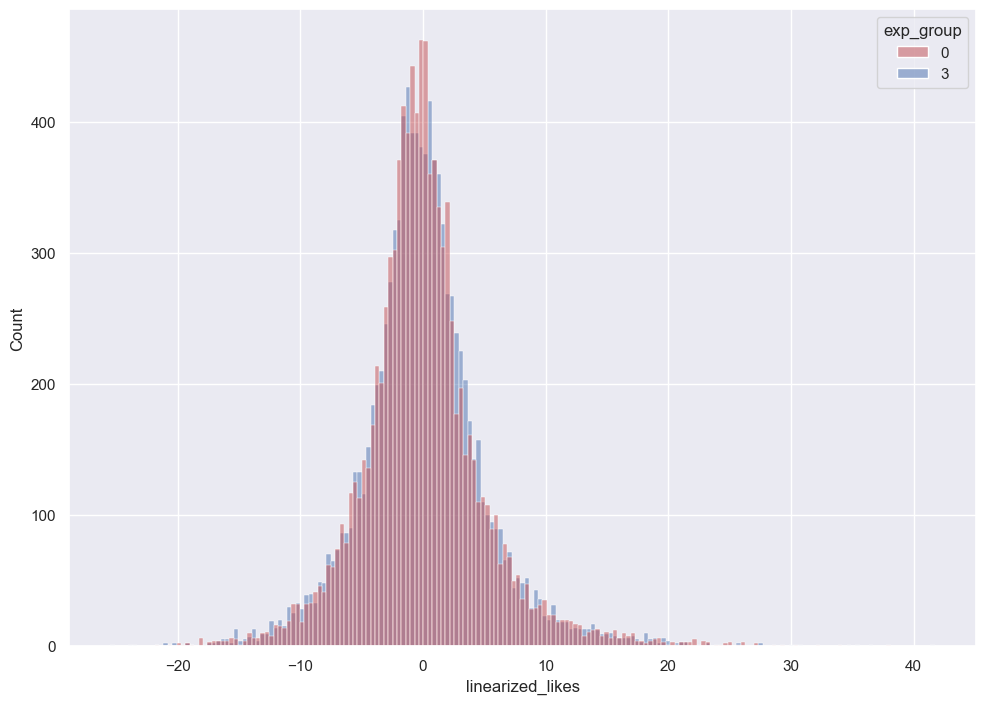

In [38]:
sns.set(rc={'figure.figsize':(11.7,8.27)})

groups = sns.histplot(data = df.query('exp_group == 0 | exp_group == 3'), 
              x='linearized_likes', 
              hue='exp_group', 
              palette = ['r', 'b'],
              alpha=0.5,
              kde=False)

In [39]:
# t-test

stats.ttest_ind(df[df.exp_group == 0].linearized_likes,
               df[df.exp_group == 3].linearized_likes,
               equal_var=False)

Ttest_indResult(statistic=-1.2237229536846168e-15, pvalue=0.999999999999999)

In [42]:
stats.mannwhitneyu(df[df.exp_group == 0].linearized_likes,
               df[df.exp_group == 3].linearized_likes,
               alternative = 'two-sided')

MannwhitneyuResult(statistic=49775173.0, pvalue=0.2566197982423696)

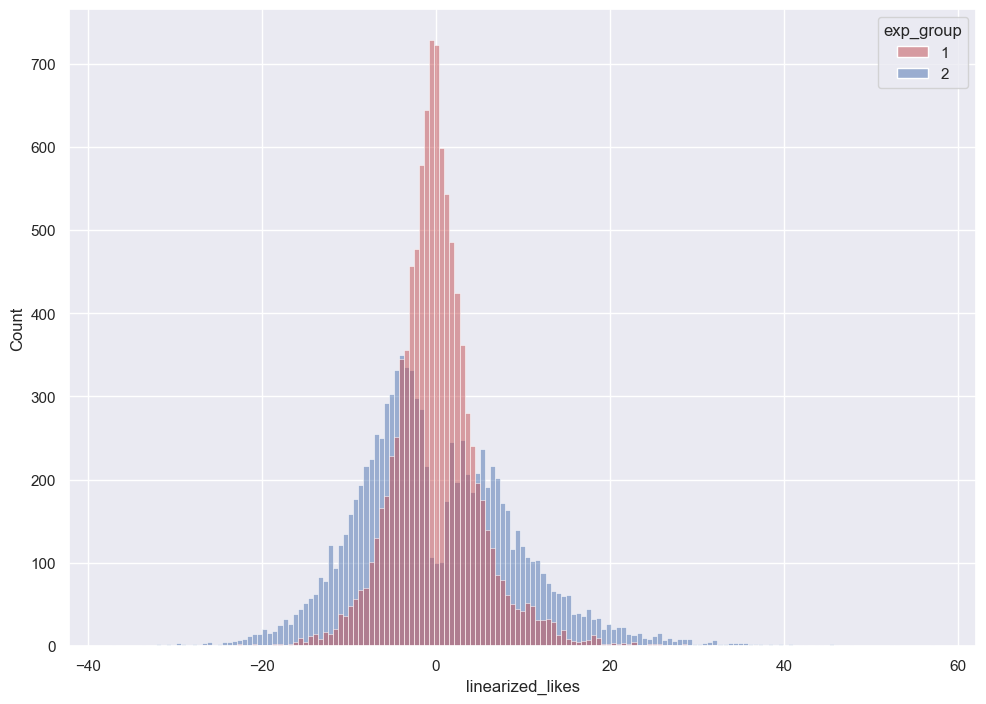

In [30]:
sns.set(rc={'figure.figsize':(11.7,8.27)})

groups = sns.histplot(data = df.query('exp_group == 1 | exp_group == 2'), 
              x='linearized_likes', 
              hue='exp_group', 
              palette = ['r', 'b'],
              alpha=0.5,
              kde=False)

In [23]:
# t-test

stats.ttest_ind(df[df.exp_group == 1].linearized_likes,
               df[df.exp_group == 2].linearized_likes,
               equal_var=False)

Ttest_indResult(statistic=-7.32460493325957e-15, pvalue=0.9999999999999942)

In [43]:
stats.mannwhitneyu(df[df.exp_group == 1].linearized_likes,
               df[df.exp_group == 2].linearized_likes,
               alternative = 'two-sided')

MannwhitneyuResult(statistic=53100508.0, pvalue=5.896781159543966e-13)

# Conclusions



Analyzing the linearized CTR for groups 0 and 3:
* visually, there is no difference between distributions and averages;
* t-test p-value is almost 1, and that means that there is no difference between means;
* Mann-Whitney p-value is above 0,05, which confirms that distributions are equal.

Analyzing the linearized CTR for groups 1 and 2:
* visually, there is a difference between distributions, but the averages look the same;
* t-test p-value is almost 1, and that means that there is no difference between means;
* Mann-Whitney p-value is way below 0,05, which confirms that distributions are unequal.